In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, NaiveSeasonal, NaiveDrift, ExponentialSmoothing
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality
from darts.metrics import mape
from darts.datasets import AirPassengersDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode
from darts.utils.missing_values import fill_missing_values
import darts

# Pandas settings
pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

from darts.models import NHiTSModel
from darts.dataprocessing.transformers import Scaler

class Darts_nHits():
    def __init__(self, solar_data):
        print('NHits Class: init')
        data_solar = solar_data
        data_solar = data_solar.rename(columns={'date': 'time', 'value': 'SolarPower[Wh]'})
        data_solar.index = pd.to_datetime(data_solar['time'])
        data_solar_interp = data_solar.interpolate(method='time')
        df_solar_resamp = data_solar_interp.resample('900S').mean()
        # Drop NaN values by interpolating
        df_solar_resamp = df_solar_resamp.interpolate(method='time')
        df_solar_resamp = df_solar_resamp.resample('900S').mean()
        # Drop NaN values
        df_solar_resamp = df_solar_resamp.dropna()
        df_solar_resamp = df_solar_resamp.drop(columns=['Unnamed: 0'], axis=1)
        df_solar_resamp = df_solar_resamp.clip(lower=0.1)
        ts_solar_df = TimeSeries.from_dataframe(df_solar_resamp, freq='900S')
        self.ts_solar_df = self.fill_missing_vals(ts_solar_df)
        self.train, self.val = self.train_test_split()
        self.ts_train, self.ts_val = self.scale_data()
        self.prediction = self.train_model()

    def fill_missing_vals(self, ts_solar_df):
        ts_solar_df = fill_missing_values(ts_solar_df, "auto")
        print('NHits Class: missing values filled')
        return ts_solar_df
    
    def train_test_split(self):
        # Split the data into training and validation sets
        # Get latest time of self.ts_solar_df
        latest_time = self.ts_solar_df.end_time()
        train, val = self.ts_solar_df.split_after(latest_time - pd.Timedelta(days=1))
        return train, val
    
    def scale_data(self):
        # Scale the data
        self.train_scaler = Scaler()
        ts_solar_train_scaled = self.train_scaler.fit_transform(self.train)
        ts_solar_val_scaled = Scaler().fit_transform(self.val)
        return ts_solar_train_scaled, ts_solar_val_scaled

    def train_model(self):
        self.nhits = NHiTSModel(
            input_chunk_length=len(self.ts_val) * 2,
            output_chunk_length=len(self.ts_val),
            random_state=32
        )
        self.nhits.fit(self.ts_train, verbose=True, epochs=200)
        scaled_pred_nhits = self.nhits.predict(n=len(self.ts_val))
        pred_nhits = self.train_scaler.inverse_transform(scaled_pred_nhits)
        return pred_nhits

In [33]:
solar_data = pd.read_csv('Dataset1/new_solar_data.csv')

NHits Class: init
NHits Class: missing values filled


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

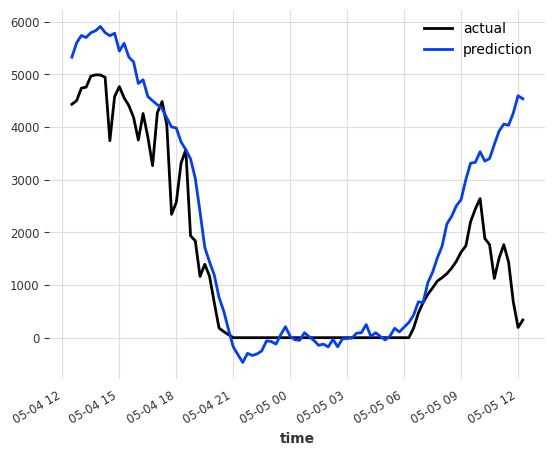

In [34]:
nhits_class = Darts_nHits(solar_data)
nhits_class.val.plot(label='actual')
nhits_class.prediction.plot(label='prediction')

In [25]:
# Plot the loss
plt.plot(nhits_class.nhits.history.loss, label='Training loss')

AttributeError: 'NHiTSModel' object has no attribute 'history'